<a href="https://colab.research.google.com/github/AURI-Kor/Deep-Learning/blob/main/koreanans_mrc_multiling_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean MRC Baseline

## Dependency
다음과 같은 라이브러리를 사용한다.
- [Konlpy](https://konlpy.org/ko/latest/index.html): 파이썬 한국어 NLP 처리기
- [Mecab-korean](https://bitbucket.org/eunjeon/mecab-ko-dic/src): 한국어 형태소 분석기

In [ ]:
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.8.2-0ubuntu2).
openjdk-8-jdk is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


## 데이터셋 구성
현재 JSON 데이터를 볼 수 있는 클래스를 하나 작성하자.

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

In [ ]:
from typing import Dict, Any
import json

class KoMRC:
  def __init__(self, data, indices):
    self._data = data
    self._indices = indices

  @classmethod
  def load(cls, file_path:str):
    with open(file_path, 'r', encoding='utf-8') as fd:
      data = json.load(fd)

    indices = []
    for d_id, document in enumerate(data['data']):
      for p_id, paragraph in enumerate(document['paragraphs']):
        for q_id, _ in enumerate(paragraph['qas']):
          indices.append((d_id, p_id, q_id))

    return cls(data, indices)

  @classmethod
  def split(cls, dataset, eval_ratio: float=.1, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)

  def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']
        qa = paragraph['qas'][q_id]

        guid = qa['guid']
        question = qa['question']
        answers = qa['answers']

        return {
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }
  def __len__(self) -> int:
        return len(self._indices)


In [ ]:
from typing import List, Tuple, Dict, Any
import json
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)

    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']
        qa = paragraph['qas'][q_id]

        guid = qa['guid']
        question = qa['question']
        answers = qa['answers']

        return {
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)


`load` 메소드를 이용해서 Json 데이터를 불러올 수 있다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/nlp/MRC'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = KoMRC.load(file_path + '/train.json')
print("Number of Samples:", len(dataset))
print(dataset[0])

Number of Samples: 12037
{'guid': '798db07f0b9046759deed9d4a35ce31e', 'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.', 'question': '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?', 'answers': [{'text': '한 달가량', 'answer_start': 478}, {'text': '한 달', 'answer_start': 478}]}


`split` 메소드를 이용하면 데이터 셋을 나눌 수 있다.

In [ ]:
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘2

단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.

In [ ]:
import konlpy
mecab = konlpy.tag.Mecab()

In [ ]:
mecab.morphs('지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다.')

['지난해',
 '주요',
 '연극',
 '상',
 '을',
 '나눠',
 '가졌',
 '던',
 '세',
 '편',
 '의',
 '작품',
 '이',
 '올',
 '봄',
 '에',
 '나란히',
 '앙코르',
 '무대',
 '를',
 '갖',
 '는다',
 '.']

In [ ]:
mecab.nouns('지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다.')

['지난해', '주요', '연극', '상', '편', '작품', '봄', '앙코르', '무대']

In [ ]:
mecab.pos('지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다.')

[('지난해', 'NNG'),
 ('주요', 'NNG'),
 ('연극', 'NNG'),
 ('상', 'NNG'),
 ('을', 'JKO'),
 ('나눠', 'VV+EC'),
 ('가졌', 'VV+EP'),
 ('던', 'ETM'),
 ('세', 'MM'),
 ('편', 'NNBC'),
 ('의', 'JKG'),
 ('작품', 'NNG'),
 ('이', 'JKS'),
 ('올', 'MM'),
 ('봄', 'NNG'),
 ('에', 'JKB'),
 ('나란히', 'MAG'),
 ('앙코르', 'NNG'),
 ('무대', 'NNG'),
 ('를', 'JKO'),
 ('갖', 'VV'),
 ('는다', 'EF'),
 ('.', 'SF')]

Mecab Tokenize의 문제점은 공백을 처리하지 못한다는 것이다.이를 해결하기 위해서 Tokenize하는 위치에 수를 달아줄 수 있다.

e.g.

'지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다.'

'0 1 2 3 4 5 6 7 8 9 10 ...'

'(0,2) (4,5) (7,8)(9,9)(10,10) ... '

|형태소|position|
|---|---|
지난해|(0,2)
주요|(4,5)
연극|(7,8)
상|(9,9)
을|(10,10)
...

-> 우리 과제에서는 정답 token과 end token을 학습데이터로 만들어야 한다,

answer이 '주요 연극상'에 해당하는 경우

Start의 경우 '주:0' end의 경우 '상:9'을 가리켜야 한다.


In [ ]:
# from typing import Generator

# import konlpy

# class TokenizedKoMRC(KoMRC):
#     def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
#         super().__init__(data, indices)
#         self._tagger = konlpy.tag.Mecab()
#         self.max_length = 450

#     def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
#         position = 0
#         tokens = []
#         # morphs의 position을 기록
#         for morph in self._tagger.morphs(sentence):
#             position = sentence.find(morph, position)
#             tokens.append((morph, (position, position + len(morph))))
#             position += len(morph)
#         return tokens
            
#     # def _trim_context(self, context: List[str], positions: List[Tuple[int, int]], answers: List[Dict[str, Any]]) -> Tuple[List[str], List[Tuple[int, int]], List[Dict[str, Any]]]:
#     #     if len(context) <= self.max_length:
#     #         return context, positions, answers

#     #     # Find the shortest answer
#     #     shortest_answer = min(answers, key=lambda x: x['end'] - x['start'])

#     #     start_token = shortest_answer['start']
#     #     end_token = shortest_answer['end']
#     #     trimmed_context = context[max(0, start_token - (self.max_length - (end_token - start_token)) // 2):min(len(context), end_token + (self.max_length - (end_token - start_token)) // 2)]
#     #     trimmed_positions = positions[max(0, start_token - (self.max_length - (end_token - start_token)) // 2):min(len(context), end_token + (self.max_length - (end_token - start_token)) // 2)]

#     #     trim_start_index = max(0, start_token - (self.max_length - (end_token - start_token)) // 2)
#     #     shortest_answer['start'] -= trim_start_index
#     #     shortest_answer['end'] -= trim_start_index

#     #     return trimmed_context, trimmed_positions, [shortest_answer]

#     ## Tokenize 진행행
#     def __getitem__(self, index: int) -> Dict[str, Any]:
#         sample = super().__getitem__(index)

#         context, position = zip(*self._tokenize_with_position(sample['context']))
#         context, position = list(context), list(position)
#         question = self._tagger.morphs(sample['question'])

#         if sample['answers'] is not None:
#             answers = []
#             for answer in sample['answers']:
#                 for start, (position_start, position_end) in enumerate(position):
#                     if position_start <= answer['answer_start'] < position_end:
#                         break
#                 else:
#                     print(context, answer)
#                     raise ValueError("No mathced start position")

#                 target = ''.join(answer['text'].split(' '))
#                 source = ''
#                 for end, morph in enumerate(context[start:], start):
#                     source += morph
#                     if target in source:
#                         break
#                 else:
#                     print(context, answer)
#                     raise ValueError("No Matched end position")

#                 answers.append({
#                     'start': start,
#                     'end': end
#                 })
#                 # Trim the context, positions, and update answer indices accordingly.
#             context, position, answers = self._trim_context(context, position, answers)
#         else:
#             answers = None
        
#         return {
#             'guid': sample['guid'],
#             'context_original': sample['context'],
#             'context_position': position,
#             'question_original': sample['question'],
#             'context': context,
#             'question': question,
#             'answers': answers
#         }

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]], pretrained_tokenizer_name="monologg/kobigbird-bert-base") -> None:
        super().__init__(data, indices)
        self._tokenizer = PreTrainedTokenizerFast.from_pretrained(pretrained_tokenizer_name)

    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        tokens = self._tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
        return list(zip(tokens.input_ids, tokens.offset_mapping))

    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)

        inputs = self._tokenizer(sample['context'], return_offsets_mapping=True, add_special_tokens=False)
        context = self._tokenizer.convert_ids_to_tokens(inputs.input_ids)
        position = inputs.offset_mapping

        question = self._tokenizer(sample['question'], return_offsets_mapping=True, add_special_tokens=False)
        question_token_strings = self._tokenizer.convert_ids_to_tokens(question.input_ids)

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    print(answer['answer_start'], len(answer['text']))
                    end = answer['answer_start'] + len(answer['text'])

                answers.append({
                    'start': answer['answer_start'],
                    'end': end
                })
        else:
            answers = None

        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question_token_strings,
            'answers': answers
        }


In [ ]:
from typing import Generator

import konlpy

class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tagger = konlpy.tag.Mecab()

    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []
        for morph in self._tagger.morphs(sentence):
            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
        return tokens
            
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)
        question = self._tagger.morphs(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No Matched end position")

                answers.append({
                    'start': start,
                    'end': end
                })
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }

In [ ]:
dataset = TokenizedKoMRC.load(file_path + '/train.json')

train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context_original': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인

In [ ]:
dev_dataset

In [ ]:
sample = dev_dataset[0]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

['서강대', '메리', '홀', '대극장']


In [ ]:
print(sample['context_position'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

[(446, 447), (448, 451), (451, 452), (453, 454), (454, 456), (456, 457), (458, 460), (460, 461), (462, 464), (464, 465), (466, 468), (468, 469)]


In [ ]:
start_pos = sample['context_position'][sample['answers'][0]['start']]
sent = (' ').join(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])
print(f'시작위치 {start_pos[0]} 번째 : {sent}')

시작위치 446 번째 : . 연출가 ##는 “ 공적 ##인 권력 ##이 사적 ##인 권리 ##를


## Vocab 생성 및 Indexing
토큰화된 데이터 셋을 기준으로 Vocab을 만들고 인덱싱을 하는 `Indexer`를 만들자.

In [ ]:
from typing import Sequence
from collections import Counter
from itertools import chain

from tqdm.notebook import tqdm

class Indexer:
    def __init__(self,
        id2token: List[str], 
        max_length: int=4096,
        pad: str='<pad>', unk: str='<unk>', cls: str='<cls>', sep: str='<sep>'
    ):
        self.pad = pad
        self.unk = unk
        self.cls = cls
        self.sep = sep
        self.special_tokens = [pad, unk, cls, sep]

        self.max_length = max_length

        self.id2token = self.special_tokens + id2token
        self.token2id = {token: token_id for token_id, token in enumerate(self.id2token)}

    @property
    def vocab_size(self):
        return len(self.id2token)
    
    @property
    def pad_id(self):
        return self.token2id[self.pad]
    @property
    def unk_id(self):
        return self.token2id[self.unk]
    @property
    def cls_id(self):
        return self.token2id[self.cls]
    @property
    def sep_id(self):
        return self.token2id[self.sep]

    @classmethod
    def build_vocab(cls,
        dataset: TokenizedKoMRC, 
        # 5개 미만 제거
        min_freq: int=5
    ):
        counter = Counter(chain.from_iterable(
            sample['context'] + sample['question']
            for sample in tqdm(dataset, desc="Counting Vocab")
        ))

        return cls([word for word, count in counter.items() if count >= min_freq])
    
    def decode(self,
        token_ids: Sequence[int]
    ):
        return [self.id2token[token_id] for token_id in token_ids]

    # encode  
    # sample = each document
    def sample2ids(self,
        sample: Dict[str, Any],
    ) -> Dict[str, Any]:
        context = [self.token2id.get(token, self.unk_id) for token in sample['context']]
        question = [self.token2id.get(token, self.unk_id) for token in sample['question']]

        # input은 [cls] [][][][][] (Quenstion Token) [SEP] [][][][][][] (Context Token) [SEP]
        # Question Token 과 Context Token을 구분하고 문장의 끝을 나타내기 위한 [SEP] Token 2개를 붙여서 input을 만든다.
        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        # ([CLS]+[Questions])[0] +([SEP]+[Answers]+[SEP])[1] 
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            # answer 중 첫번째 정답만을 label로 사용용
            answer = sample['answers'][0]
            # question 길이 + 2 1024가 넘지 않게끔 맞춰준다.
            start = min(answer['start'] + len(question) + 2, self.max_length - 1)
            end = min(answer['end'] + len(question) + 2, self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [ ]:
# data build
indexer = Indexer.build_vocab(dataset)
print(indexer.sample2ids(dev_dataset[0]))

Counting Vocab:   0%|          | 0/12037 [00:00<?, ?it/s]

{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람

쉽게 Indexer를 활용하기 위해 Indexer가 포함된 데이터 셋을 만들자.

In [ ]:
# index sample마다 적용하여 돌리는 것은 문제를 겪을 수 있다.
# 따라서 index를 wrapping한다.
class IndexerWrappedDataset:
    # data와 index를 받아 len과 item을 반환하는 구조체를 만든다.
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        # 길이가 맞지 않는 pad 위치를 무시하기 위해 길이만큼 [1]을 반환한다.
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample


In [ ]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
# input_ids + attention_mask + token_type_ids ...
print(sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], sample['start'], sample['end'])

[2, 1, 1100, 7, 2226, 71, 4336, 30, 25656, 1139, 97, 57, 39, 2874, 39, 2684, 974, 170, 3, 67, 2912, 4336, 830, 97, 1250, 1278, 553, 1607, 2344, 41, 2239, 30, 4, 3276, 32, 6946, 25656, 4344, 82, 2339, 1386, 15, 1016, 4336, 257, 4355, 695, 4344, 4335, 830, 66, 2412, 4336, 830, 2239, 695, 2386, 695, 4355, 830, 17, 97, 834, 71, 183, 36128, 12542, 588, 8, 64, 90, 9, 276, 142, 1, 4335, 4333, 29910, 66, 132, 9, 64, 246, 130, 530, 9, 24315, 19208, 1, 29106, 4333, 175, 66, 4336, 257, 11, 257, 74, 6503, 1, 97, 649, 20, 183, 2830, 7, 635, 30, 14, 588, 85, 9, 64, 246, 130, 1375, 9, 276, 142, 1, 19205, 175, 66, 4336, 257, 2239, 695, 2226, 830, 74, 33837, 4336, 830, 834, 28079, 183, 1, 588, 246, 130, 1513, 64, 85, 9, 6741, 1807, 1011, 29910, 175, 30, 14, 15, 9493, 1293, 2500, 20, 5450, 135, 74, 981, 20, 2426, 17, 43, 1139, 97, 11653, 4336, 2839, 7081, 9478, 2462, 2239, 332, 97, 4133, 20, 17011, 97, 12211, 407, 402, 38, 39, 950, 14, 15, 183, 36128, 12542, 191, 39, 2386, 97, 2286, 243, 2226, 71, 1, 41

## Transformer Encoder를 활용한 MRC 모델
![Bert for MRC](https://miro.medium.com/max/340/1*cXDOP0gsE7Zp8-sgZqYfTA.png)

Transformer 인코더 마지막에 Linear Layer를 붙여 정답의 시작과 끝을 맞추는 간단한 모델을 생성보자.

In [ ]:
# import torch.nn as nn

# from transformers.models.bert.modeling_bert import (
#     BertModel,
#     BertPreTrainedModel
# )

# ## Simple Version for Bert QA: https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForQuestionAnswering.forward
# class BertForQuestionAnswering(BertPreTrainedModel):
#     _keys_to_ignore_on_load_unexpected = [r"pooler"]

#     def __init__(self, config):
#         super().__init__(config)
#         self.bert = BertModel(config, add_pooling_layer=False)
#         self.start_linear = nn.Linear(config.hidden_size, 1)
#         self.end_linear = nn.Linear(config.hidden_size, 1)

#         self.init_weights()

#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         token_type_ids=None
#     ):
#         outputs = self.bert(
#             input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#         )

#         start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
#         end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

#         return start_logits, end_logits

In [ ]:
# import torch.nn as nn

# from transformers.models.longformer.modeling_longformer import (
#     LongformerModel,
#     LongformerPreTrainedModel
# )

# class LongformerForQuestionAnswering(LongformerPreTrainedModel, config):
#     _keys_to_ignore_on_load_unexpected = [r"pooler"]

#     def __init__(self, config):
#         super().__init__(config)
#         self.longformer = LongformerModel(config, add_pooling_layer=False)
#         self.start_linear = nn.Linear(config.hidden_size, 1)
#         self.end_linear = nn.Linear(config.hidden_size, 1)

#         self.init_weights()

#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         token_type_ids=None
#     ):
#         outputs = self.longformer(
#             input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#         )

#         start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
#         end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

#         return start_logits, end_logits

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import (BigBirdConfig, 
                          BigBirdForQuestionAnswering,
                          AutoTokenizer,
                          BigBirdModel,
                          BigBirdTokenizerFast)
import torch

## Simple Version for Bert QA: https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForQuestionAnswering.forward
class BigBirdForQuestionAnswering(BigBirdForQuestionAnswering):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.bert = BigBirdModel(config, add_pooling_layer=False)
        self.start_linear = nn.Linear(config.hidden_size, 1)
        self.end_linear = nn.Linear(config.hidden_size, 1)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
        end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

        return start_logits, end_logits

## 학습 준비

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {
            key: [sample[key] for sample in samples]
            for key in samples[0]
        }

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence(
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_id
            )

        return samples

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
accumulation = 4 # 메모리를 아끼기 위하여 Gradient accumulation을 해보자

collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size//accumulation, shuffle=True, collate_fn=collator, num_workers=2)
dev_loader = DataLoader(indexed_dev_dataset, batch_size=batch_size//accumulation, shuffle=False, collate_fn=collator, num_workers=2)

In [ ]:
batch = next(iter(dev_loader))
print(batch['input_ids'].shape)
print(batch['input_ids'])
print(list(batch.keys()))

torch.Size([16, 864])
tensor([[    2,     1,  1100,  ...,     0,     0,     0],
        [    2,   317,  3922,  ...,     0,     0,     0],
        [    2,    71,  6098,  ...,     0,     0,     0],
        ...,
        [    2,    63,   126,  ...,     0,     0,     0],
        [    2, 31351, 18205,  ...,     0,     0,     0],
        [    2, 35161, 14899,  ...,     0,     0,     0]])
['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'attention_mask']


In [ ]:
print(batch)

{'guid': ['844e22ab28924c1697d5ac28801b34c1', '31650c1dfb3a46c09c6600cfc31b1ec4', '925dbda8c7a0474a832b87e99c6afaec', 'f15f6ce1a422400c951878df7649b12d', '2824772bc3ce4aaba089c192b30a7dc3', '73c4446c192846208336410e3bfe9d05', 'f0f59825d2634635a4615476a506a4e9', '6253d0278e264a28a048f8bf986b8b57', 'dfe026ffcaf24af9862df6d77b5a183b', '517499a00e6648df8dbf2983dfa7d8f0', '5a3eb435d5a84bc4b2d0605482e9f063', 'c9deb14d44864dc8b2233c97f8a0f20b', '8ca9849a6e0c4556b71dc4741eaaadbc', 'af834608c3d040a9b7f50d40482b136b', '559f205f0bb04808ab80486bdc21b05d', '448674e1c5b346db8d5b7b47425876a5'], 'context': ['지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개

In [ ]:
# import torch
# from transformers import BertConfig

# torch.manual_seed(42)
# BERT_model = "beomi/kcbert-base"
# config = BertConfig(
#      vocab_size=indexer.vocab_size,
#      max_position_embeddings=1024,
#      hidden_size=256,
#      num_hidden_layers=4,
#      num_attention_heads=4,
#      intermediate_size=1024
# )
# model = BertForQuestionAnswering(config)
# # model.cuda()
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torch_xla

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'


In [ ]:
from transformers import (BigBirdConfig, 
                          BigBirdForQuestionAnswering,
                          AutoTokenizer,
                          BigBirdModel,
                          BigBirdTokenizerFast,
                          AutoConfig)
from transformers import get_linear_schedule_with_warmup

# config = BertConfig(
#      vocab_size=indexer.vocab_size,
#      max_position_embeddings=1024,
#      hidden_size=256,
#      num_hidden_layers=4,
#      num_attention_heads=4,
#      intermediate_size=1024
# )
train_dataset_size = len(train_loader.dataset)
batch_size = train_loader.batch_size

num_epochs = 30
total_steps = (train_dataset_size // batch_size) * num_epochs
warmup_ratio = 0.1
warmup_steps = int(total_steps * warmup_ratio)

kobigbird = "monologg/kobigbird-bert-base"
config = AutoConfig.from_pretrained(kobigbird)
model = BigBirdForQuestionAnswering.from_pretrained(kobigbird)
model = BigBirdForQuestionAnswering(config)

device = 'CUDA'

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.pooler.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.weight']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

In [ ]:
model.tpu()

AttributeError: ignored

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=cc113df3f90320cac6687f4a7e6c199ce0719a2aa26a4cd6ce10ca1a2a15927c
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
    project='MRC',
    name='hanbert_schedulerWithWarmUp',
    group='3oorm',
    tags=['longformer', 'base']
)

wandb: Currently logged in as: auriwall (3oorm). Use `wandb login --relogin` to force relogin


['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'attention_mask']

In [ ]:
pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.1 MB/s eta 0:00:00


In [ ]:
import os
from statistics import mean

import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import difflib

import Levenshtein  # Levenshtein 패키지를 가져옵니다.

os.makedirs('KoBigBird', exist_ok=True)
train_losses = []
dev_losses = []
train_levenshtein_distances = []
dev_levenshtein_distances = []

step = 0

for epoch in range(1, 31):
    print("Epoch", epoch)
    # Training
    running_loss = 0.
    losses = []
    levenshtein_distances = []
    progress_bar = tqdm(train_loader, desc='Train')
    for batch in progress_bar:
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.to(device) for key, value in batch.items()}
        start = batch.pop('start')
        end = batch.pop('end')

        start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)
        (loss / accumulation).backward()
        running_loss += loss.item()

        # Calculate Levenshtein distance
        start_pred, end_pred = torch.argmax(start_logits, dim=1), torch.argmax(end_logits, dim=1)
        for i, (s, e) in enumerate(zip(start_pred, end_pred)):
            pred_ans = batch['input_ids'][i][s:e].tolist()
            true_ans = batch['input_ids'][i][start[i]:end[i]].tolist()
            pred_ans_str = ' '.join(indexer.decode(pred_ans))
            true_ans_str = ' '.join(indexer.decode(true_ans))
            levenshtein_distances.append(Levenshtein.distance(pred_ans_str, true_ans_str))
        
        scheduler.step()

        del batch, start, end, start_logits, end_logits, loss
        
        step += 1
        if step % accumulation:
            continue

        clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        losses.append(running_loss / accumulation)
        running_loss = 0.
        progress_bar.set_description(f"Train - Loss: {losses[-1]:.3f}")
    train_losses.append(mean(losses))
    train_levenshtein_distances.append(mean(levenshtein_distances))
    print(f"train score: {train_losses[-1]:.3f}, train levenshtein distance: {train_levenshtein_distances[-1]:.3f}")


    # Evaluation
    losses = []
    levenshtein_distances = []
    for batch in tqdm(dev_loader, desc="Evaluation"):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.to(device) for key, value in batch.items()}
        start = batch.pop('start')
        end = batch.pop('end')

        with torch.no_grad():
            start_logits, end_logits = model(**batch)
        
        with torch.no_grad():
            start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

        start_pred, end_pred = torch.argmax(start_logits, dim=1), torch.argmax(end_logits, dim=1)
        for i, (s, e) in enumerate(zip(start_pred, end_pred)):
            pred_ans = batch['input_ids'][i][s:e].tolist()
            true_ans = batch['input_ids'][i][start[i]:end[i]].tolist()
            pred_ans_str = ' '.join(indexer.decode(pred_ans))
            true_ans_str = ' '.join(indexer.decode(true_ans))
            levenshtein_distances.append(Levenshtein.distance(pred_ans_str, true_ans_str))
        
        losses.append(loss.item())
        del batch, start, end, start_logits, end_logits, loss
    dev_losses.append(mean(losses))
    dev_levenshtein_distances.append(mean(levenshtein_distances))
    print(f"Evaluation score: {dev_losses[-1]:.3f}, evaluation levenshtein distance: {dev_levenshtein_distances[-1]:.3f}")
    wandb.log({'loss':(dev_losses[-1]), 'levenshtein distance':(dev_levenshtein_distances[-1])})

    model.save_pretrained(f'KoBigBird/KoBigBird_scheduler.{epoch}')

Epoch 1


Train:   0%|          | 0/678 [00:00<?, ?it/s]

NameError: ignored

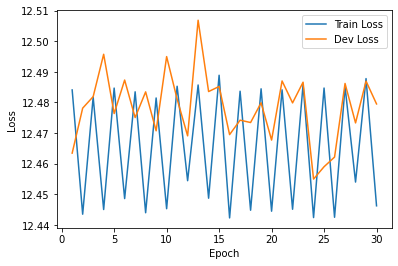

In [ ]:
import matplotlib.pyplot as plt

t = list(range(1, 31))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


![loss_plot](https://github.com/mynsng/mynsng.github.io/blob/master/assets/images/__results___26_0.png?raw=true)

학습 데이터 셋에 Overfitting이 일어나는 것을 확인할 수 있다.

## Answer Inference
모델의 Output을 활용해서 질문의 답을 찾는 코드를 작성하자.

In [ ]:
model = BertForQuestionAnswering.from_pretrained('dump/model_HanBERT_Trimmed.30')
model = model.to(device)
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    with torch.no_grad():
        start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start = sample['position'][start][0]
    end = sample['position'][end][1]

    if end - start > 10:
      end = start = sample['position'][start][0] + 5

    print('Answer:', sample['context'][start:end])

NameError: ignored

## Test 출력 파일 작성

In [ ]:
test_dataset = TokenizedKoMRC.load(file_path + '/test.json')
test_dataset = IndexerWrappedDataset(test_dataset, indexer)
print("Number of Test Samples", len(test_dataset))
print(test_dataset[0])

Number of Test Samples 4008
{'guid': 'd14cb73158624cf094c546d856fd3c80', 'context': 'BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에디션’을 한정 출시한다고 밝혔다. 이번 BMW 코리아 25주년 에디션(이하 25주년 에디션)은 BMW 3시리즈와 5시리즈, 7시리즈, 8시리즈 총 4종, 6개 모델로 출시되며, BMW 클래식 모델들로 선보인 바 있는 헤리티지 컬러가 차체에 적용돼 레트로한 느낌과 신구의 조화가 어우러진 차별화된 매력을 자랑한다. 먼저 뉴 320i 및 뉴 320d 25주년 에디션은 트림에 따라 옥스포드 그린(50대 한정) 또는 마카오 블루(50대 한정) 컬러가 적용된다. 럭셔리 라인에 적용되는 옥스포드 그린은 지난 1999년 3세대 3시리즈를 통해 처음 선보인 색상으로 짙은 녹색과 풍부한 펄이 오묘한 조화를 이루는 것이 특징이다. M 스포츠 패키지 트림에 적용되는 마카오 블루는 1988년 2세대 3시리즈를 통해 처음 선보인 바 있으며, 보랏빛 감도는 컬러감이 매력이다. 뉴 520d 25주년 에디션(25대 한정)은 프로즌 브릴리언트 화이트 컬러로 출시된다. BMW가 2011년에 처음 선보인 프로즌 브릴리언트 화이트는 한층 더 환하고 깊은 색감을 자랑하며, 특히 표면을 무광으로 마감해 특별함을 더했다. 뉴 530i 25주년 에디션(25대 한정)은 뉴 3시리즈 25주년 에디션에도 적용된 마카오 블루 컬러가 조합된다. 뉴 740Li 25주년 에디션(7대 한정)에는 말라카이트 그린 다크 색상이 적용된다. 잔잔하면서도 오묘한 깊은 녹색을 발산하는 말라카이트 그린 다크는 장식재로 활용되는 광물 말라카이트에서 유래됐다. 뉴 840i xDrive 그란쿠페 25주년 에디션(8대 한정)은 인도양의 맑고 투명한 에메랄드 빛을 연상케 하는 몰디브 블루 컬러로 출시된다. 특히 몰디브 블루는 지난 1993년 1세대 8시리즈에 처음으로 적용되었던 만큼 이를 오마주하는 의미를 담

In [ ]:
import csv

os.makedirs(file_path+'out', exist_ok=True)
with torch.no_grad(), open(file_path+'out/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    
    for sample in tqdm(test_dataset, "Testing"):
        input_ids, token_type_ids = [
            torch.tensor(sample[key], dtype=torch.long, device="cuda")
            for key in ("input_ids", "token_type_ids")
        ]
        
        max_length = 512
        input_ids = input_ids[:max_length]
        token_type_ids = token_type_ids[:max_length]

        with torch.no_grad():
            start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
        start_logits.squeeze_(0), end_logits.squeeze_(0)
    
        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
        index = torch.argmax(probability).item()
    
        start = index // len(end_prob)
        end = index % len(end_prob)
    
        start = sample['position'][start][0]
        end = sample['position'][end][1]

        rows.append([sample["guid"], sample['context'][start:end]])
    
    writer.writerows(rows)

NameError: ignored